In [1]:
import nltk
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /home/tms8p/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package treebank to /home/tms8p/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package conll2000 to /home/tms8p/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/tms8p/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

___________________________
### Prepare Dataset

In [3]:
# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')

# Merge corpora
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [4]:
X = [] # store input sequence
Y = [] # store output tags
for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for pair in sentence: 
        X_sentence.append(pair[0]) # the word
        Y_sentence.append(pair[1]) # the tag
 
    X.append(X_sentence)
    Y.append(Y_sentence)

In [5]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags = len(set([word.lower() for sentence in Y for word in sentence]))

______________________________
### Tokenize and Pad

In [6]:
# encode X
word_tokenizer = Tokenizer()              # instantiate tokeniser
word_tokenizer.fit_on_texts(X)            # fit tokeniser on data

# use the tokeniser to encode input sequence
X_encoded = word_tokenizer.texts_to_sequences(X)  

# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [7]:
# sequences greater than 100 in length will be truncated
MAX_SEQ_LENGTH = 100
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')

________________________
### Split Data into Training and Testing Data

In [8]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y_padded, test_size=0.25, random_state=4)

______________________________
### Create word embedding matrix with Word2Vec Data 

In [9]:
import gensim.downloader
glove_vectors = gensim.downloader.load('word2vec-google-news-300')

In [10]:
from gensim.models import KeyedVectors

# word2vec
path = "gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

# assign word vectors from word2vec model
# each word in word2vec model is represented using a 300 dimensional vector
EMBEDDING_SIZE = 300
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

________________________
### One-hot encode Y

In [11]:
# use Keras' to_categorical function to one-hot encode Y
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

_______________________________
### Data Shapes

In [12]:
print("Training shapes:\n")
print(X_train.shape)
print(Y_train.shape)
print("\nTesting Shapes:\n")
print(X_test.shape)
print(Y_test.shape)

Training shapes:

(54151, 100)
(54151, 100, 13)

Testing Shapes:

(18051, 100)
(18051, 100, 13)


___________________________
### Ignore accuracy of paddings

In [13]:
def accuracy_masked_class(to_ignore=0):
    def accuracy_masked(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_true_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return accuracy_masked

_________________________________
### Build and Train Model

In [42]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(input_dim   = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
model.add(layers.Conv1D(128, kernel_size=2, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=1, strides=1, padding='same'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(13, activation='softmax'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(13, activation='softmax'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(13, activation='softmax'))
model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Adam(),
 metrics=[keras.metrics.CategoricalAccuracy(), accuracy_masked_class(0)])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          17834700  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 128)          76928     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
dense_8 (Dense)              (None, 100, 128)          16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
dense_9 (Dense)              (None, 100, 13)          

In [47]:
history = model.fit(X_train, Y_train,
                    epochs=20,
                    validation_data=(X_test, Y_test),
                    batch_size=256)

Epoch 1/10
212/212 [==============================] - 87s 408ms/step - loss: 0.0138 - categorical_accuracy: 0.9961 - accuracy_masked: 0.9814 - val_loss: 0.0306 - val_categorical_accuracy: 0.9927 - val_accuracy_masked: 0.9650
Epoch 2/10
212/212 [==============================] - 168s 793ms/step - loss: 0.0134 - categorical_accuracy: 0.9961 - accuracy_masked: 0.9817 - val_loss: 0.0315 - val_categorical_accuracy: 0.9926 - val_accuracy_masked: 0.9647
Epoch 3/10
212/212 [==============================] - 204s 960ms/step - loss: 0.0131 - categorical_accuracy: 0.9962 - accuracy_masked: 0.9820 - val_loss: 0.0304 - val_categorical_accuracy: 0.9924 - val_accuracy_masked: 0.9640
Epoch 4/10
212/212 [==============================] - 207s 976ms/step - loss: 0.0128 - categorical_accuracy: 0.9963 - accuracy_masked: 0.9823 - val_loss: 0.0305 - val_categorical_accuracy: 0.9924 - val_accuracy_masked: 0.9638
Epoch 5/10
212/212 [==============================] - 200s 944ms/step - loss: 0.0125 - categorica

_____________________________________________
### Testing Original Sentences

Text(0.5, 1.0, 'model loss')

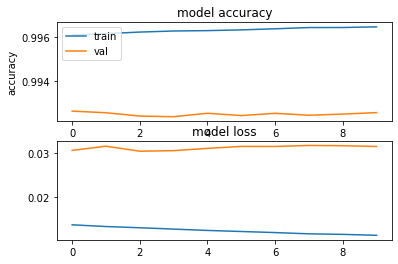

In [48]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 

In [49]:
score = model.evaluate(X_train, Y_train, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.00903103593736887
Test accuracy: 0.9970415830612183


In [46]:
from nltk.tokenize import word_tokenize

def output_prediction(text):
    # Pre-process data like we did for training.
    text = [word_tokenize(text)]
    text_encoded = word_tokenizer.texts_to_sequences(text) 
    text_padded = pad_sequences(text_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
    
    # Make a prediction
    ynew = np.argmax(model.predict(text_padded), axis=-1)
    prediction = ynew[0]
    
    # Trim leading zeros
    prediction = np.trim_zeros(prediction)
        
    # Decode prediction
    decoded = tag_tokenizer.sequences_to_texts([prediction])
    
    # show the inputs and predicted outputs
    print("X= %s\nPredicted= %s" % (text, decoded))
    
text = "This is a simple sentence."
output_prediction(text)

X= [['This', 'is', 'a', 'simple', 'sentence', '.']]
Predicted= ['det verb det adj noun .']
